In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import nengo
import nengolib
import numpy as np
import pandas as pd

Let's see if we can get Aaron's delay network to recognize two different patterns. First, let's create the patterns. For this simple test, we'll just use a 1Hz sine wave and a 0.5Hz sine wave for the two patterns.

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (9,166,167,168,169,170,171,174,175,176,177) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


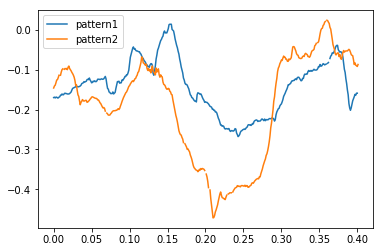

In [14]:
s_pattern = 402                # number of data points in the pattern
t = np.arange(s_pattern)*0.001  # time points for the elements in the patter

data = pd.read_csv("pinsoro-2017-06-01-102743523980.csv")

pattern1 = data.iloc[1983:2385,190]
pattern2 = data.iloc[2386:2788,190]

plt.plot(t, pattern1, label='pattern1')
plt.plot(t, pattern2, label='pattern2')
plt.legend(loc='best')
plt.show()

Now let's create a network that represents a rolling window in time (Aaron's "delay network"). The process determines what sort of pattern the network will be optimized for -- here we just go with white noise of a maximum of 3Hz.  theta determines how big the rolling window is -- here we use 0.5 seconds.

In [24]:
net = nengo.Network()
with net:
    process = nengo.processes.WhiteSignal(period=100., high=3., y0=0)
    rw = nengolib.networks.RollingWindow(theta=0.5, n_neurons=3000, process=process, neuron_type=nengo.LIFRate())

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\filter_design.py:1551: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


Now we need to create the training data for decoding out of the rolling window. Our patterns are larger than the rolling window, so to create our training data we will take our patterns, shift them, and cut them down to the right size. In order to then give that to nengo, we also need to project from the window's space to the internal representation space (using the inv_basis).

The target array is the desired output value for each of the slices of the pattern in eval_points. We'll use 1 for pattern1 and -1 for pattern2.

In [25]:
s_window = 402

t_window = np.linspace(0, 1, s_window)
inv_basis = rw.inverse_basis(t_window)
    
eval_points = []
target = []
for i in range(s_pattern):
    eval_points.append(np.dot(inv_basis, np.roll(pattern1, i)[:s_window]))
    target.append([1])
    eval_points.append(np.dot(inv_basis, np.roll(pattern2, i)[:s_window]))
    target.append([-1])

Now we can create a connection optimized to do this decoding

In [26]:
with net:
    result = nengo.Node(None, size_in=1)
    nengo.Connection(rw.state, result,
                     eval_points=eval_points, scale_eval_points=False,
                     function=target, synapse=0.1)

Let's try feeding in those two patterns and see what the response is

In [27]:
model = nengo.Network()
model.networks.append(net)
with model:
    freqs = [1, 0.5]
    def stim_func(t):
        freq = freqs[int(t/5) % len(freqs)]
        return np.sin(t*2*np.pi*freq)
    
    stim = nengo.Node(stim_func)
    nengo.Connection(stim, rw.input, synapse=None)
    
    p_result = nengo.Probe(result)
    p_stim = nengo.Probe(stim)
sim = nengo.Simulator(model)
sim.run(10)

plt.plot(sim.trange(), sim.data[p_stim], label='input')
plt.plot(sim.trange(), sim.data[p_result], label='output')
plt.legend(loc='best')

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\neurons.py:422: RuntimeWarning: invalid value encountered in greater
  self.tau_ref + self.tau_rc * np.log1p(1. / j[j > 0]))


BuildError: Building <Connection from <Ensemble "state"> to <Node (unlabeled) at 0x28bf13c1eb8> computing 'ndarray'>: 'activities' matrix is all zero for <Ensemble "state">. This is because no evaluation points fall in the firing ranges of any neurons.

It successfully detects the two frequencies, outputting 1 for the 1Hz pattern (pattern1) and -1 for the 0.5Hz (pattern2)!

Note that it has never observed a transition between frequencies, so it's somewhat reasonable that it's confused at the transitions. This could be fixed by adding more training data that includes such transitions.

Now let's try intermediate frequencies that it has never seen before:

In [28]:
model = nengo.Network()
model.networks.append(net)
with model:
    freqs = [1, 0.5, 0.75, 0.875, 0.625]
    def stim_func(t):
        freq = freqs[int(t/5) % len(freqs)]
        return np.sin(t*2*np.pi*freq)
    
    stim = nengo.Node(stim_func)
    nengo.Connection(stim, rw.input, synapse=None)
    
    p_result = nengo.Probe(result)
    p_stim = nengo.Probe(stim)
sim = nengo.Simulator(model)
sim.run(25)

plt.plot(sim.trange(), sim.data[p_stim], label='input')
plt.plot(sim.trange(), sim.data[p_result], label='output')
plt.legend(loc='best')

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengolib\signal\system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

C:\Users\mbartlett2\AppData\Local\Continuum\anaconda3\lib\site-packages\nengo\neurons.py:422: RuntimeWarning: invalid value encountered in greater
  self.tau_ref + self.tau_rc * np.log1p(1. / j[j > 0]))


BuildError: Building <Connection from <Ensemble "state"> to <Node (unlabeled) at 0x28bf13c1eb8> computing 'ndarray'>: 'activities' matrix is all zero for <Ensemble "state">. This is because no evaluation points fall in the firing ranges of any neurons.

The network successfully interpolates between the two patterns it was trained on!